# Applied Data Science Capstone Project 

### Using machine learning and Foursquare to determine the place location to open an Italian restaurant in NYC

#### By: Tevin Richard

## 1. Import required libraries

In [2]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import requests
import folium
import geocoder
import urllib.request
from urllib.request import urlopen
from geopy.geocoders import Nominatim
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# configure libraries settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline


print("All libraries have been successfully imported")

All libraries have been successfully imported


## 2. Define  function to get  geographical latitude and longitude for a locartion using the geopy library

In [154]:
# Function inputs: 
# 1. Address of location to be evaluated for latitude and longitude

def location(address): 
    geolocator = Nominatim(user_agent="newyork_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    
    return latitude, longitude

# Function outputs:
# 1. Address latitude
# 2. Address longitude

## 3. Define function to retrieve restaurant venues for a give address from the Foursquare API. 

In [12]:
# Function inputs: 
# 1. No specific input required.

def retrieve_nyc_info():
    url='https://cocl.us/new_york_dataset' 
    
    # Connect to the dataset and extract the json format data
    response1=requests.get(url).json() 
    
    # The required info is stored in the features section of the request. 
    features=response1['features']
    
    # Specify the names of the columns for the dataframe to be created
    df_columnn_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    
    # Create the blank data frame for which the resulst from the for loop will be appended to
    nyc_data = pd.DataFrame(columns=df_columnn_names)
    
    # Create the for loop that will run through each row in the features data and extract the desired info
    for entry in features:
        borough_name = entry['properties']['borough'] # Extract the name of the Borough
        nbh_name = entry['properties']['name']        # Extratc the name of the Neighbourhood
        nbh_coordinates = entry['geometry']['coordinates'] # Extract the neighbourhood latitude and longitude
        nbh_latitude = nbh_coordinates[1]
        nbh_longitude = nbh_coordinates[0]
    
        # Append the retrieved data to the original dataframe
        nyc_data = nyc_data.append({'Borough': borough_name,
                                          'Neighborhood': nbh_name,
                                          'Latitude': nbh_latitude,
                                          'Longitude': nbh_longitude}, ignore_index=True)
    
    return nyc_data

# Function outputs
#1. Dataframe of NYC Neighbourhoods and their respective latitudes and longitudes

In [13]:
# Extract the latitude and longitudes for NYC neighborhoods in each Borough

nyc_data = retrieve_nyc_info()
nyc_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [14]:
#Evaluate the dataset 

print("The dataset has {} rows and {} colmns".format(nyc_data.shape[0],nyc_data.shape[1]))
print("Therefore there are {} neighbourhoods amongst the various Boroughs in NYC".format(nyc_data.shape[0]))

The dataset has 306 rows and 4 colmns
Therefore there are 306 neighbourhoods amongst the various Boroughs in NYC


## 4.Group the data according to number of neighborhoods per Borough

In [15]:
# create a new dataframe for holding the count neighborhoods per Borough
nyc_data_sorted = pd.DataFrame(nyc_data.groupby('Borough').count()['Neighborhood'])

# Arrange the venues in ascending order to visually identify the neighborhoods with the least number of Italian restaurants
nyc_data_sorted.sort_values("Neighborhood",
                            ascending="False",
                            inplace=True)

nyc_data_sorted 

,Neighborhood
Borough,
Manhattan,40
Bronx,52
Staten Island,63
Brooklyn,70
Queens,81


<AxesSubplot:xlabel='Borough', ylabel='Number of Neighborhoods per Borough'>

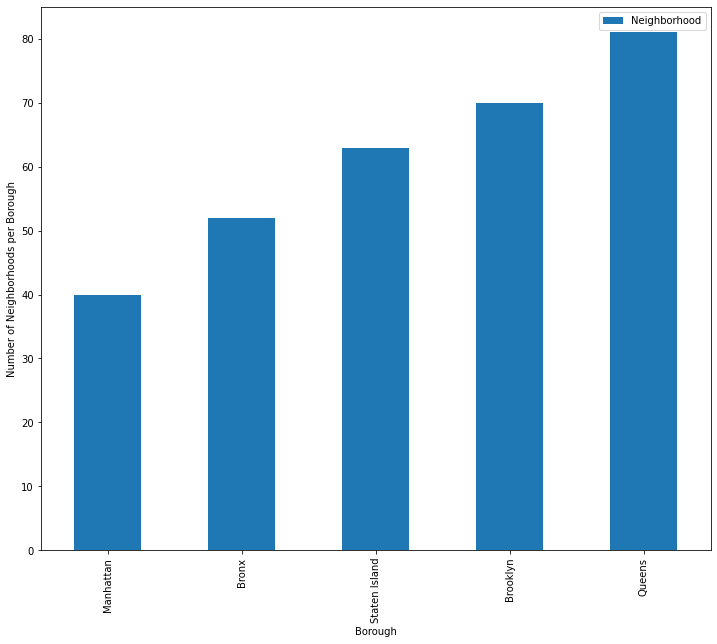

In [16]:
nyc_data_sorted.plot(figsize = (12,10),
                               kind='bar',
                               xlabel ="Borough",
                               ylabel= "Number of Neighborhoods per Borough",
                               legend = "Borough"
                              )

## 5. Analyze the data to determine which Borough is best to start a business in

According to https://www.extraspace.com/blog/moving/city-guides/best-boroughs-nyc/, Manhattan is the best Borough for Dining and Nightlife. This suggests that Manhattan is the sought after Borough for food lovers. I will therefore choose Manahattan as the Borough to further analyze for an ideal location to start-up an Italian restaurant. 

Furthermore, based on the plot above,  Manhattan has the least number of neighbourhoods. This would also be the best choice for the purposes of this project since this would limit the number of Foursquare API requests made for the free developer account. 


## 6. Create a function to retrieve data for nearby Italian restaurants per NYC Manhattan neighbohood from the Foursquare API


The unique Foursquare ID for Italian restaurants is 4bf58dd8d48988d110941735 (https://gist.github.com/mraaroncruz/0a9e4968f7149821ca74).  This ID will be used when making the Foursquare API calls.

In [17]:
# 4bf58dd8d48988d110941735 - ID for Italian restaurant category

import urllib
def getNearbyVenues(names,           # Names of the NYC neighborhoods
                    latitudes,       # Latitude of neighborhood
                    longitudes,      # Longitude of neighborhood
                    radius=5000,     # Default radius to search within
                    categoryIds=''): # Unique Foursquare category ID
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['id'],
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue','Venue ID', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [176]:
# Define Foursquare application required user inputs
LIMIT = 5000         # Limit the API call to 500
radius = 5000        # As per default function radius
CLIENT_ID = ''       # Uniquie user Client ID
CLIENT_SECRET = ''   # Uni1uie user Client secret
VERSION = '20201020' # Foursquare version

In [18]:
# Refine the nyc_data dataframe to only include results for the Manhattan Borough
nyc_data = nyc_data[nyc_data['Borough']== 'Manhattan'].reset_index(drop=True)

# Use the created function from above to retrieve Italian restaurants in Manhattan neighborhoods
nyc_ital_rest = getNearbyVenues(names=nyc_data['Neighborhood'],
                                latitudes=nyc_data['Latitude'],
                                longitudes=nyc_data['Longitude'],
                                radius=1000,                            # Limit search to 1000 m radius of each NYC Manhattan neighborhood
                                categoryIds='4bf58dd8d48988d110941735') # Unique ID for Italian restaurants

nyc_ital_rest.head()

UnboundLocalError: local variable 'url' referenced before assignment

In [179]:
# Check the shape of dataframe with all Italian restaurants in NYC, Mahanttan
nyc_ital_rest.shape

(1493, 8)

Export the results to a CSV to prevent calling the Foursquare API each time the script is run

In [180]:
#nyc_ital_rest.to_csv("https://github.com/tevinric/Coursera_Capstone/blob/main/ital_rest_new2.csv")

Reload the data file (csv) into pandas from Github repository. This will allow an auditor to load load the data and run the code below

In [47]:
path0 = "https://raw.githubusercontent.com/tevinric/Coursera_Capstone/2f4399b8b58bf895b6e80a7cbbd05b6de55b3756/ital_rest_new2.csv"
nyc_ital_rest = pd.read_csv(path0)
nyc_ital_rest

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,0,Marble Hill,40.876551,-73.910660,Arturo's,4b4429abf964a52037f225e3,40.874412,-73.910271,Pizza Place
1,1,Marble Hill,40.876551,-73.910660,Broadway Pizza & Pasta,4be72770910020a16f1ad514,40.878822,-73.904494,Pizza Place
2,2,Marble Hill,40.876551,-73.910660,Patricia's of Tremont,4df272a918386ecb4e2cab2a,40.882543,-73.913501,Italian Restaurant
3,3,Marble Hill,40.876551,-73.910660,pinochio pizza,5302a84a11d26be8acd6bd89,40.877868,-73.918948,Italian Restaurant
4,4,Marble Hill,40.876551,-73.910660,Nonno Tony's,4b784cd3f964a5206ac32ee3,40.885288,-73.909588,Italian Restaurant
5,5,Chinatown,40.715618,-73.994279,Bacaro,472a027af964a520ea4b1fe3,40.714468,-73.991589,Italian Restaurant
6,6,Chinatown,40.715618,-73.994279,Forsythia,5f21f95204091a2439ed691b,40.722550,-73.992485,Italian Restaurant
7,7,Chinatown,40.715618,-73.994279,Zia Maria Little Italy,5c89cad22632ec002c2722d4,40.718504,-73.997465,Italian Restaurant
8,8,Chinatown,40.715618,-73.994279,Gran Tivoli,5c6f559535811b002c0d4496,40.721011,-73.997645,Italian Restaurant
9,9,Chinatown,40.715618,-73.994279,Kimika,5f375ed976cccc26893db65a,40.720581,-73.995314,Japanese Restaurant


Clean the data and remove unnecessary columns

In [186]:
nyc_ital_rest = nyc_ital_rest.drop(["Unnamed: 0"], axis=1)

In [187]:
# Check to ensure that the shape of the data was retained
nyc_ital_rest.shape

(1493, 8)

## 7. Plot the location of the NYC Manhattan Italian restaurants using Folium

In [19]:
# First create a function to add each venue location to the map 
# Inputs 
# 1. Data frame containing locations of venues
# 2. Color mapping
# 3. Folium map create for location

def venue_mapping(dataframe, color, nyc_map):
    for latitude, longitude, local, venue, venue_category in zip(dataframe['Venue Latitude'], dataframe['Venue Longitude'], dataframe['Neighborhood'], dataframe['Venue'], dataframe['Venue Category']):
        marker_label = '{} ({}) - {}'.format(venue, venue_category, local)
        marker_label = folium.Popup(marker_label, parse_html=True)
        folium.CircleMarker(
        [latitude, longitude],
        radius=4,
        popup=marker_label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(nyc_map)

Create the map of NYC upon which all Italian restaurants will be superimposed onto

In [11]:
# Specify the area to be plotted - New York City in this case
address = 'New York City, NY'

# Use Geocoder Library to extract latitude and longitude of the desired address
geolocator = Nominatim(user_agent="ny_explorer")
ny_location = geolocator.geocode(address)
ny_latitude = ny_location.latitude
ny_longitude = ny_location.longitude

# Plot the map to show all Manhattan italian restaurants
nyc_ital_rest_map = folium.Map(location= [ny_latitude, ny_longitude],zoom_start=10)
venue_mapping(nyc_ital_rest, 'red', nyc_ital_rest_map)

nyc_ital_rest_map

NameError: name 'venue_mapping' is not defined

### Comments:

This provides a visualisation of the distribution of Italian restaurants in NYC, Manhattan. However this does not help make decision on the best location to open a business since the points are too clustered. Therefore  evaluate the number of restaurants per neighbourhood to get a better idea of which Neighborhoods have the least number of Italian restaurants. 


### 8. Group the Manhattan Neighborhoods by the count of Italian restaurants per neighborhood

<AxesSubplot:xlabel='NYC Manhatttan Neighborhood', ylabel='Number of Italian Restuarants per Neighborhood'>

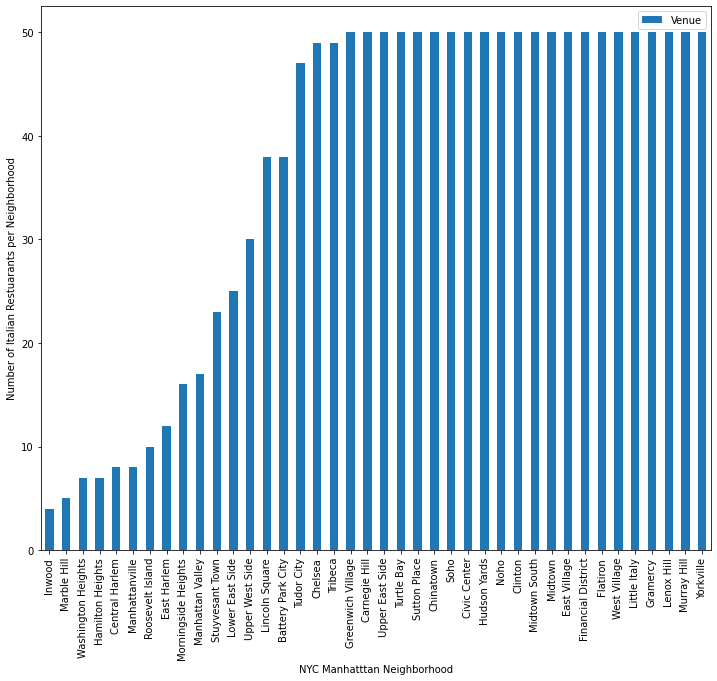

In [56]:
# create a new dataframe for holding the count of italian restaurants per neighborhood in Manhattan
nyc_ital_rest_sorted_desc = pd.DataFrame(nyc_ital_rest.groupby('Neighborhood').count()['Venue'])

# Arrange the venues in ascending order to visually identify the neighborhoods with the least number of Italian restaurants
nyc_ital_rest_sorted_desc.sort_values("Venue", ascending="False", inplace=True)

#create the plot

nyc_ital_rest_sorted_desc.plot(figsize = (12,10),
                               kind='bar',
                               xlabel ="NYC Manhatttan Neighborhood",
                               ylabel= "Number of Italian Restuarants per Neighborhood",
                               legend = "Neighborhood"
                              )

In [57]:
nyc_ital_rest_sorted_desc

,Venue
Neighborhood,
Inwood,4
Marble Hill,5
Washington Heights,7
Hamilton Heights,7
Central Harlem,8
Manhattanville,8
Roosevelt Island,10
East Harlem,12
Morningside Heights,16


### Comments 

From the results above, it is clear that following neighborhoods have the least number of Italian restaurants: 

1. Inwood
2. Marble Hill
3. Washington Heights
4. Hamilton Heights
5. Central Harlem

These will be considered as the top 5 neighborhoods to consider since these would have the lowest levels of competitiion. 

### 9. Extract ratings for each of the Italian restaurants to further classify competitors and likely areas for start-up

Create a function to now pull the ratings, likes and tips for each italian restaurant in the dataset

In [194]:
def get_venue_details(venue_id):
        
    CLIENT_ID = ''        # unique Foursquare ID
    CLIENT_SECRET = ''    # unque Foursquare Secret
    VERSION =  '20201020' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### NOTE: 

The Foursquare developer service only allows 500 premiums calls (for likes, rating and tips data). Therefore the original data set will be divided into 3 partitions. Each partition will be evaluated seperated and the data will be rejoined. 

This will allow for getting the required stats for all restaurants in the NYC Italian restaurants dataset. 

#### 9.1 Split the original dataset into smaller subsets(partitions) that can be analyzed despite the Foursquare application call limitations

In [196]:
nyc_ital_rest_tot = nyc_ital_rest

# Create the first partition which will hold ~ 33% of the original dataset
nyc_ital_rest1 = nyc_ital_rest_tot.sample(frac=0.3333, random_state=200)
# Remove the first partition from the original dataset so that the
# remaining data can be further split
nyc_ital_rest_remaining1 = nyc_ital_rest_tot.drop(nyc_ital_rest1.index)

#  Create the second partition 
nyc_ital_rest2 = nyc_ital_rest_remaining1.sample(frac=0.5, random_state=200)
# Remove the second partition from the original dataset so that the
# remaining data can be further split
nyc_ital_rest_remaining2 = nyc_ital_rest_remaining1.drop(nyc_ital_rest2.index)

# Create the third partition from the remaining data in the original set.
nyc_ital_rest3 = nyc_ital_rest_remaining2

In [197]:
print("Size of partition 1 is {} rows and {} columns ".format(nyc_ital_rest1.shape[0],nyc_ital_rest1.shape[1]))
print("Size of partition 2 is {} rows and {} columns ".format(nyc_ital_rest2.shape[0],nyc_ital_rest2.shape[1]))
print("Size of partition 3 is {} rows and {} columns ".format(nyc_ital_rest3.shape[0],nyc_ital_rest3.shape[1]))
print("Toal size of set is {} rows and {} columns ".format(nyc_ital_rest.shape[0],nyc_ital_rest.shape[1]))

Size of partition 1 is 498 rows and 8 columns 
Size of partition 2 is 498 rows and 8 columns 
Size of partition 3 is 497 rows and 8 columns 
Toal size of set is 1493 rows and 8 columns 


Save each of the Partitions to CSV to avoid random resplit

In [198]:
# This section is commented out since it has already been completed

#nyc_ital_rest1.to_csv("save_path")
#nyc_ital_rest2.to_csv("save_path")
#nyc_ital_rest3.to_csv("save_path")

Reload partitions into sub dataframes

#### 9.2 Acquiring restaurant stats for Partition 1

Load partition 1 into pandas

In [22]:
nyc_ital_rest1 = pd.read_csv("https://raw.githubusercontent.com/tevinric/Coursera_Capstone/main/nyc_ital_rest_data_partition_1.csv")

Perform cleaning on partition 1 in preparation for getting stats from Foursquare

In [23]:
# Set the index to the original dataset indices
nyc_ital_rest1 = nyc_ital_rest1.set_index("Unnamed: 0") 

# Rename columns 
nyc_ital_rest1.rename(columns={"Venue":"Name"}, inplace=True) 
nyc_ital_rest1 = nyc_ital_rest1.rename(columns ={"Venue ID": "ID",
                                                 "Neighborhood Latitude" :"NeighborhoodLatitude",
                                                 "Neighborhood Latitude" :"NeighborhoodLatitude",
                                                 "Venue Latitude" :"VenueLatitude",
                                                 "Venue Longitude" :"VenueLongitude",
                                                 "Venue Category" :"VenueCategory"
                                                })

# Drop the columns that are not required
nyc_ital_rest1_dropped = nyc_ital_rest1.drop(columns=["NeighborhoodLatitude",
                                                       "Neighborhood Longitude",
                                                        "VenueLatitude",
                                                        "VenueLatitude",
                                                       "VenueLongitude",
                                                       "VenueCategory"])

# Rearrange the order of columns 
columns_rearranged1= ["Neighborhood", "ID", "Name"]
nyc_ital_rest1_dropped = nyc_ital_rest1_dropped.reindex(columns = columns_rearranged1 )
 
nyc_ital_rest1_dropped.head()

,Neighborhood,ID,Name
Unnamed: 0,,,
1110,Noho,4a790030f964a520cbe61fe3,Luzzo's
54,Chinatown,5ae016fc2faed54a007fbb89,Una Pizza Napoletana
1177,Midtown South,5b5b8ac6c21cb1002c540c6f,Cardoncello DiVino
653,Tribeca,4a149749f964a52055781fe3,Locanda Verde
1360,Tudor City,4afa15d8f964a520931622e3,Villa Berulia


### NOTE:

The section below is commented out since the data has already been retrieved. 

This section will extract the stats data (likes, ratings, tips) for each Italian restaurant in the partition 1 data set

In [24]:
### Key:
#  - Single hashtag indicates a code line that was commented out 
## - Double hashtag indicates a comment line

## get data for first partition
#column_names=['Neighborhood','ID', 'Name','Likes','Rating','Tips']

## create a dataframe to store the extrated results
# nyc_ital_rest1_stats = pd.DataFrame(columns= column_names)

## Create a for loop to go throigh each row in partition 1 dataframe
#for row in nyc_ital_rest1_dropped.values.tolist():
#    Neighborhood, ID, Name =row

#    try:
        ## Use the created function to call ratings, likes and tips for each of the venue IDs in the data frame
#        venue_details = get_venue_details(ID)
#        id, name, likes, rating, tips =venue_details.values.tolist()[0]
#    except IndexError:
        ## Restaurants that have no details will be assigned a value of zero (0)
#        id,name,likes,rating,tips=[0]*5
#    nyc_ital_rest1_stats = nyc_ital_rest1_stats.append({
#                                                'Neighborhood': Neighborhood,
#                                                'ID' :id,
#                                                'Name' : name,
#                                                'Likes' : likes,
#                                                'Rating' : rating,
#                                                'Tips' : tips
#                                               }, ignore_index=True)

Write the results for partition 1 with the extracted stats to a new data frame to call up again. Prevents making requests to the foursqure API again

In [25]:
#Commented out to prevent overwrite
#nyc_ital_rest1_stats.to_csv("save_path")

In [29]:
nyc_ital_rest1_stats_read = pd.read_csv("https://raw.githubusercontent.com/tevinric/Coursera_Capstone/main/nyc_ital_rest1_stats.csv")

Clean up the results:

In [30]:
nyc_ital_rest1_stats_read.drop(columns=["Neighborhood", "Unnamed: 0"], axis=1, inplace=True)
nyc_ital_rest1_stats_read.reset_index

<bound method DataFrame.reset_index of                            ID  \
0    4a790030f964a520cbe61fe3   
1    5ae016fc2faed54a007fbb89   
2    5b5b8ac6c21cb1002c540c6f   
3    4a149749f964a52055781fe3   
4    4afa15d8f964a520931622e3   
5    3fd66200f964a520dbe91ee3   
6    53726183498e6a101ea7fd06   
7    50e6eae5e4b06de013260a31   
8    49bd2326f964a5204d541fe3   
9    4c7ee13301df37044eaee4ac   
10   56d8e01d498ef1500ae7fbfe   
11   549d841d498e8b6d495e5f25   
12   55835b10498e4d4b71a919c7   
13   4f44a2bd19836ed0019571be   
14   5be4c3afda5e560039aee110   
15   4b4d140bf964a5202aca26e3   
16   4b4cc1f2f964a52087bd26e3   
17   5282b4bf11d2b180cc775713   
18   4ba293adf964a520ef0538e3   
19   5bc67f67898bdc002c570600   
20   52f8ed59498ede6f715776d8   
21   504b2a9ee4b006c435a465d3   
22   5396110b498ecef1832bd696   
23   58252ebad02c06429707be49   
24   59dc07609ef8ef6202638fba   
25   567f3485498e0948d80ffcfd   
26   3fd66200f964a520f4e41ee3   
27   4aa7a44ef964a520e44c20e3   
28  

Merge the stats results together with original partition 1 dataset to get a complete dataset

In [31]:
nyc_ital_rest1_merged = pd.concat([nyc_ital_rest1, nyc_ital_rest1_stats_read], axis=1)
nyc_ital_rest1_merged.drop(columns=["Venue", "Venue ID", "Tips"], axis=1, inplace= True)
nyc_ital_rest1_merged.head()

KeyError: "['Venue' 'Venue ID' 'Tips'] not found in axis"

#### 9.3 Acquiring restaurant stats for Partition 2

Load Partition 2 into pandas

In [32]:
nyc_ital_rest2 = pd.read_csv("https://raw.githubusercontent.com/tevinric/Coursera_Capstone/main/nyc_ital_rest_data_partition_2.csv")

Perform cleaning on partition 2 in preparation for getting stats from Foursquare

In [33]:
# Set the index to the original dataset indices
nyc_ital_rest2 = nyc_ital_rest2.set_index("Unnamed: 0") 

# Rename columns
nyc_ital_rest2.rename(columns={"Venue":"Name"}, inplace=True) 
nyc_ital_rest2 = nyc_ital_rest2.rename(columns ={"Venue ID": "ID",
                                                 "Neighborhood Latitude" :"NeighborhoodLatitude",
                                                 "Neighborhood Latitude" :"NeighborhoodLatitude",
                                                 "Venue Latitude" :"VenueLatitude",
                                                 "Venue Longitude" :"VenueLongitude",
                                                 "Venue Category" :"VenueCategory"
                                                })

# Drop the columns that are not required
nyc_ital_rest2_dropped = nyc_ital_rest2.drop(columns=["NeighborhoodLatitude",
                                                       "Neighborhood Longitude",
                                                        "VenueLatitude",
                                                        "VenueLatitude",
                                                       "VenueLongitude",
                                                       "VenueCategory"])

# Rearrange the order of columns 
columns_rearranged2= ["Neighborhood","ID","Name"]
nyc_ital_rest2_dropped = nyc_ital_rest2_dropped.reindex(columns = columns_rearranged2 )
                                                       
                                                                           

nyc_ital_rest2_dropped.head()

,Neighborhood,ID,Name
Unnamed: 0,,,
1198,Midtown South,4a807240f964a52040f51fe3,Coppola's
736,Little Italy,3fd66200f964a520dbe91ee3,Lupa
1428,Flatiron,44ae8bc6f964a52027351fe3,Vezzo Thin Crust Pizza
410,Midtown,3fd66200f964a5209ee81ee3,Carmine’s Italian Restaurant
929,Gramercy,40f1d480f964a520680a1fe3,Hearth


In [34]:
### Key:
#  - Single hashtag indicates a code line that was commented out 
## - Double hashtag indicates a comment line

## Get data for second partition
#column_names=['Neighborhood','ID', 'Name','Likes','Rating','Tips']
              
# nyc_ital_rest2_stats = pd.DataFrame(columns= column_names)

#for row in nyc_ital_rest2_dropped.values.tolist():
#    Neighborhood, ID, Name =row

#    try:
        ## Use the created function to call ratings, likes and tips for each of the venue IDs in the data frame
        #venue_details = get_venue_details(ID)
        #id, name, likes, rating, tips =venue_details.values.tolist()[0]
    #except IndexError:
         ## Restaurants that have no details will be assigned a value of zero (0)
        #id,name,likes,rating,tips=[0]*5
    #nyc_ital_rest2_stats = nyc_ital_rest2_stats.append({
#                                                'Neighborhood': Neighborhood,
#                                                'ID' :id,
#                                                'Name' : name,
#                                                'Likes' : likes,
#                                                'Rating' : rating,
#                                                'Tips' : tips
#                                               }, ignore_index=True)

Write the results for partition 2 with the extracted stats to a new data frame to call up again. Prevents making requests to the foursqure API again

In [35]:
#Commented out to prevent overwrite
#nyc_ital_rest2_stats.to_csv("Save_path")

In [36]:
nyc_ital_rest2_stats_read = pd.read_csv("https://raw.githubusercontent.com/tevinric/Coursera_Capstone/main/nyc_ital_rest2_stats.csv")

Clean up the results:

In [37]:
nyc_ital_rest2_stats_read.drop(columns=["Neighborhood", "Unnamed: 0"], axis=1, inplace=True)
nyc_ital_rest2_stats_read.reset_index

<bound method DataFrame.reset_index of                            ID  \
0    4a807240f964a52040f51fe3   
1    3fd66200f964a520dbe91ee3   
2    44ae8bc6f964a52027351fe3   
3    3fd66200f964a5209ee81ee3   
4    40f1d480f964a520680a1fe3   
5    4adce863f964a5206c6221e3   
6    3fd66200f964a520f4e41ee3   
7                           0   
8    4b0ddac5f964a520645123e3   
9    4ba56a50f964a520df0439e3   
10   4c353f26452620a1a292260f   
11                          0   
12   543c7c63498e0a3393da47a2   
13   524f650e11d2b2e01dc964f8   
14                          0   
15   4b720a32f964a5209b6b2de3   
16   3fd66200f964a520a5e31ee3   
17                          0   
18   4a149749f964a52055781fe3   
19   5365a69c498e43ca2718d05c   
20   506e48ffe4b078ebe1c30a29   
21   4b9e79e4f964a52035e736e3   
22                          0   
23   4e0a4deba80926c35bb46df2   
24   49f20537f964a520d3691fe3   
25   5421eb06498e1b6b9c1bfd9c   
26   4b3bedfaf964a5209e7e25e3   
27   4b2042fff964a5208f2f24e3   
28  

Merge the stats results together with original partition 2 dataset to get a complete dataset

In [231]:
nyc_ital_rest2_merged = pd.concat([nyc_ital_rest1, nyc_ital_rest2_stats_read], axis=1)
nyc_ital_rest2_merged.drop(columns=["Venue", "Venue ID", "Tips"], axis=1, inplace= True)
nyc_ital_rest2_merged.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category,ID,Name,Likes,Rating
0,1110,Noho,40.723259,-73.988434,40.730565,-73.983191,Pizza Place,4a807240f964a52040f51fe3,Coppola's,41,7.9
1,54,Chinatown,40.715618,-73.994279,40.721750,-73.988589,Pizza Place,3fd66200f964a520dbe91ee3,Lupa,553,8.8
2,1177,Midtown South,40.748510,-73.988713,40.745090,-73.990090,Italian Restaurant,44ae8bc6f964a52027351fe3,Vezzo Thin Crust Pizza,775,8.8
3,653,Tribeca,40.721522,-74.010683,40.719981,-74.010002,Italian Restaurant,3fd66200f964a5209ee81ee3,Carmine’s Italian Restaurant,1617,8.3
4,1360,Tudor City,40.746917,-73.971219,40.746863,-73.980620,Italian Restaurant,40f1d480f964a520680a1fe3,Hearth,585,8.7


#### 9.4 Acquiring restaurant stats for Partition 3

Load Partition 3 into pandas

In [232]:
nyc_ital_rest3 = pd.read_csv("https://raw.githubusercontent.com/tevinric/Coursera_Capstone/main/nyc_ital_rest_data_partition_3.csv")

Perform cleaning on partition 3 in preparation for getting stats from Foursquare

In [233]:
# Set the index to the original dataset indices
nyc_ital_rest3 = nyc_ital_rest3.set_index("Unnamed: 0") 

# Rename columns
nyc_ital_rest3.rename(columns={"Venue":"Name"}, inplace=True) 
nyc_ital_rest3 = nyc_ital_rest3.rename(columns ={"Venue ID": "ID",
                                                 "Neighborhood Latitude" :"NeighborhoodLatitude",
                                                 "Neighborhood Latitude" :"NeighborhoodLatitude",
                                                 "Venue Latitude" :"VenueLatitude",
                                                 "Venue Longitude" :"VenueLongitude",
                                                 "Venue Category" :"VenueCategory"
                                                })

nyc_ital_rest3_dropped = nyc_ital_rest3.drop(columns=["NeighborhoodLatitude",
                                                       "Neighborhood Longitude",
                                                        "VenueLatitude",
                                                        "VenueLatitude",
                                                       "VenueLongitude",
                                                       "VenueCategory"])

# Rearrange the order of columns 
columns_rearranged3= ["Neighborhood","ID","Name"]
nyc_ital_rest3_dropped = nyc_ital_rest3_dropped.reindex(columns = columns_rearranged3 )

nyc_ital_rest3_dropped.head()

,Neighborhood,ID,Name
Unnamed: 0,,,
0,Marble Hill,4b4429abf964a52037f225e3,Arturo's
3,Marble Hill,5302a84a11d26be8acd6bd89,pinochio pizza
7,Chinatown,5c89cad22632ec002c2722d4,Zia Maria Little Italy
10,Chinatown,5070d27ae4b0513ffd4ddfe7,Trapizzino
11,Chinatown,5ce7332c1acf11002cd8cf3d,Arancini Bros


In [236]:
### Key:
#  - Single hashtag indicates a code line that was commented out 
## - Double hashtag indicates a comment line

## Get data for thrid partition
#column_names=['Neighborhood','ID', 'Name','Likes','Rating','Tips']
              
# nyc_ital_rest3_stats = pd.DataFrame(columns= column_names)
## Create a counter to pass through each row in the dataframe

#for row in nyc_ital_rest3_dropped.values.tolist():
#    Neighborhood, ID, Name =row

#    try:
##        Use the created function to call ratings, likes and tips for each of the venue IDs in the data frame
#        venue_details = get_venue_details(ID)
#        id, name, likes, rating, tips =venue_details.values.tolist()[0]
#    except IndexError:
##       Restaurants that have no details will be assigned a value of zero (0)
#        id,name,likes,rating,tips=[0]*5
#    nyc_ital_rest3_stats = nyc_ital_rest3_stats.append({
#                                                'Neighborhood': Neighborhood,
#                                                'ID' :id,
#                                                'Name' : name,
#                                                'Likes' : likes,
#                                                'Rating' : rating,
#                                                'Tips' : tips
#                                               }, ignore_index=True)

Write the results for partition 3 with the extracted stats to a new data frame to call up again. Prevents making requests to the foursqure API again

In [26]:
#Commented out to prevent overwrite
#nyc_ital_rest3_stats.to_csv("Save_path")

In [38]:
nyc_ital_rest3_stats_read = pd.read_csv("https://raw.githubusercontent.com/tevinric/Coursera_Capstone/main/nyc_ital_rest3_stats.csv")

Clean up the results:

In [39]:
nyc_ital_rest3_stats_read.drop(columns=["Neighborhood", "Unnamed: 0"], axis=1, inplace=True)
nyc_ital_rest3_stats_read.reset_index

<bound method DataFrame.reset_index of                            ID  \
0    4b4429abf964a52037f225e3   
1                           0   
2    5c89cad22632ec002c2722d4   
3    5070d27ae4b0513ffd4ddfe7   
4                           0   
5                           0   
6    4bf2d441e5eba59347da1d90   
7                           0   
8    49dad010f964a520b15e1fe3   
9    4d9f8d97a428a1cdd92acb04   
10   4be1bcf53ef676b05651c0ca   
11   4c7d4f1b8da18cfa1afc9ece   
12   4b1c3950f964a520970424e3   
13   44c0ed2df964a520b1351fe3   
14   3fd66200f964a520ade61ee3   
15   40fb0f00f964a520db0a1fe3   
16   51c4bbd02fc62fbffb241861   
17   52698f5911d23c1c66d64564   
18                          0   
19                          0   
20                          0   
21   4310fe80f964a52050271fe3   
22                          0   
23   505380aee4b07ab78c6545fe   
24                          0   
25   457f1183f964a5204b3f1fe3   
26   56d8e01d498ef1500ae7fbfe   
27                          0   
28  

Merge the stats results together with original partition 3 dataset to get a complete dataset

In [40]:
nyc_ital_rest3_merged = pd.concat([nyc_ital_rest1, nyc_ital_rest3_stats_read], axis=1)
nyc_ital_rest3_merged.drop(columns=["Venue", "Venue ID", "Tips"], axis=1, inplace= True)
nyc_ital_rest3_merged.head()

KeyError: "['Venue' 'Venue ID' 'Tips'] not found in axis"

#### 9.5 Join all partitons together 

In [41]:
nyc_ital_restaurants_ratings_0 = nyc_ital_rest1_merged.append(nyc_ital_rest2_merged)
nyc_ital_restaurants_ratings   = nyc_ital_restaurants_ratings_0.append(nyc_ital_rest3_merged)
nyc_ital_restaurants_ratings.head()

NameError: name 'nyc_ital_rest2_merged' is not defined

Save the merged dataset to prevent requirement for reloading data

In [241]:
# save the reconciled partitions to csv
#nyc_ital_restaurants_ratings.to_csv("Save_Path")

In [42]:
nyc_ital_restaurants_ratings = pd.read_csv("https://raw.githubusercontent.com/tevinric/Coursera_Capstone/main/nyc_ital_restaurants_ratings.csv")

Clean up the results to remove all rows in which stats were not available and also all rows that contain NaN values

In [43]:
# drop all the rows in which there are no data for ratings
nyc_ital_restaurants_ratings.drop(nyc_ital_restaurants_ratings.loc[nyc_ital_restaurants_ratings["Rating"]==0].index, inplace=True)

#drop all NaN values in the Datafram
nyc_ital_restaurants_ratings.dropna(inplace=True)

## 10. Use K-Means clustering to cluster the Italian restaurants data

Clustering will be based in likes and ratings of each the Italian restaurants

In [5]:
# Drop all non-required columns
nyc_ital_rest1_merged_kmeans = nyc_ital_restaurants_ratings.drop(columns=["Unnamed: 0","Unnamed: 0.1", "Neighborhood","Neighborhood Latitude", "Neighborhood Longitude", "Venue Latitude","Venue Longitude","Venue Category", "ID", "Name"])

Set up the K-Means algorithm

In [6]:
#Import the required library 
from sklearn.cluster import KMeans

# Set the number of clusters required
kclusters = 5

# Instantiate the K-Means unsupervised learning algorithm
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_ital_rest1_merged_kmeans)

# Retrive the K-Means clustering lables for the first 5 data entries
kmeans.labels_[0:]

array([0, 2, 2, ..., 2, 2, 2])

In [7]:
# Join the clustering lables back to the original dataset 
nyc_ital_rest_clustered = nyc_ital_restaurants_ratings
nyc_ital_rest_clustered.insert(0, "Clustering Lables", kmeans.labels_)

In [8]:
# clean up non-essential columns
nyc_ital_rest_clustered.drop(columns=["Unnamed: 0","Unnamed: 0.1"], inplace=True)

In [21]:
# Get the centroids to better understand the clusters 
nyc_ital_rest_clustered.groupby('Clustering Lables').mean()

,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Likes,Rating
Clustering Lables,,,,,,
0,40.742723,-73.986828,40.743520,-73.987250,421.261682,8.529907
1,40.724783,-73.995446,40.728753,-73.993936,8129.000000,9.300000
2,40.746314,-73.984011,40.746860,-73.984290,71.165226,7.610855
3,40.741975,-73.988493,40.742978,-73.988784,979.592105,8.782895
4,40.731694,-73.990566,40.733081,-73.990482,2497.000000,9.300000


## Comments: 

From the centroidsof the clusters , the following observations can be made: 

1. Cluster 0 - Contains low likes & highly rated Italian restaurants
2. Cluster 1 - Contains highly liked & highly rated Italian restaurants
3. Cluster 2 - Contains low likes & lowly rated Italian restaurants 
4. Cluster 3 - Contains medium liked and highly rated Italian restaurants
5. Cluster 4 - Contains highly liked and highly rated Italian restaurants

Clusters 1 and 4 contain highly liked and highly rated restaurants (Best to avoid opening in areas that contain alot of restaurants in Cluster 1 and 4 - Very high competition that is popular) 

Cluster 0 and 3 contain low and medium liked restaurants with relatively high ratings. It would not be a good idea to open a restaurant in areas that have alot of restaurants in these clusters. These are restaurants that will be hard to compete with as a new business. 

Cluster 2 contains relatively lowly liked and rated Italian restaurants. Areas that have alot of Cluster 2 restaurants will be the best/ideal areas to open a NEW business since the competition will be relatively low. This will increase the chances of success for a new start-up business.

## 11. Plot all Italian restaurants according to their respective clusters

In [20]:
# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_ital_rest_clustered['Venue Latitude'], nyc_ital_rest_clustered['Venue Longitude'], nyc_ital_rest1_clustered['Neighborhood'], nyc_ital_rest1_clustered['Clustering Lables']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

NameError: name 'nyc_ital_rest1_clustered' is not defined

## 12. Group the Italian Restaurants based on average neighborhood ratings

<AxesSubplot:xlabel='NYC Manhatttan Neighborhood', ylabel='Average Rating'>

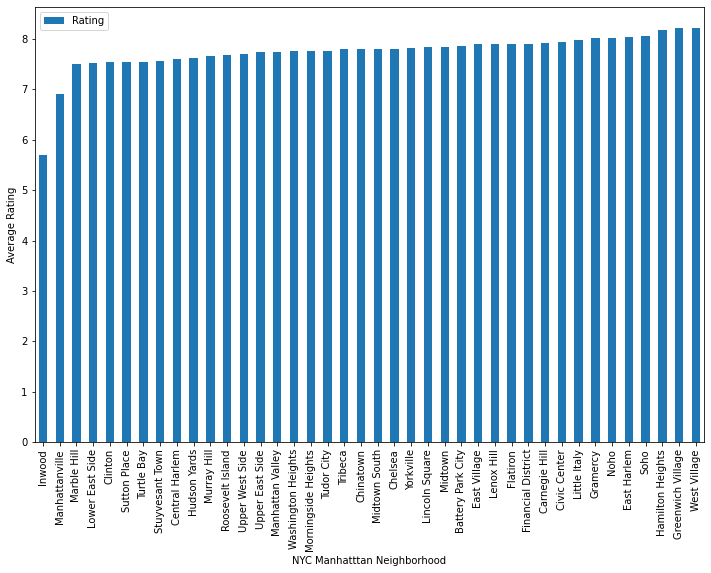

In [265]:
# create a new dataframe for holding average ratings of all Italian Restaurants per Neighborhood
nyc_ital_rest_neigh_avg = pd.DataFrame(nyc_ital_rest_clustered.groupby('Neighborhood').mean()['Rating'])

# Arrange the venues in ascending order to visually identify the neighborhoods with the highest and lowest ratings
nyc_ital_rest_neigh_avg.sort_values("Rating", ascending="False", inplace=True)

#create the plot
nyc_ital_rest_neigh_avg.plot(figsize = (12,8),
                               kind='bar',
                               xlabel ="NYC Manhatttan Neighborhood",
                               ylabel= "Average Rating",
                              )

## Comments:

The bar chart shows the average rating of Italian Restaurants per neighborhood. From this chart, it is apparent that the 5 lowest rated Neighborhoods for Italian cuisine are: 

1. Inwood
2. Manhattanville
3. Marble Hill
4. Lower East Side
5. Clinton

It is also apparent that the 5 highest rated NYC Manhattan neighborhoods are: 

1. West Village
2. Greenwich Village
3. Hamilton Heights
4. Soho
5. East Harlem 

Therefore is will not be worth opening an Italian restuarant in these 5 neighborhoods since it already has established restaurants that are highly rated - High levels of competition. 

From step 8, it was found that the following 5 Neighborhoods have the least number of Italian Restaurants: 

1. Inwood
2. Marble Hill
3. Washington Heights
4. Hamilton Heights
5. Central Harlem

Combining the results of the above analyses together, it is observed that the Inwood and Marble Hill neighborhoods would be the best neighborhoods to open a new Italian restaurant. This is beacuse:
1. They have the lowest number of Italian restaurants already
2. They have the lowest customer ratings 

These allow one to assume that the levels of competition with respect to Italian Restaurants in Inwood and Marble Hill are low. Therefore either neighborhood would be a good choice to open a new Italian Restaurant. 

Lets analyse both Neighborhoods further



## 13. Analyse each of the shortlised Neighborhoods

### 13.1 Inwood Neighborhood

In [45]:
#create another dataframe that shows all rated Italian restaurants in best neighborhood (Inwood)

nyc_ital_rest_inwood_rated = nyc_ital_rest_clustered.loc[nyc_ital_rest_clustered['Neighborhood'] == 'Inwood']
nyc_ital_rest_inwood_rated

,Clustering Lables,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category,ID,Name,Likes,Rating
953,2,Inwood,40.867684,-73.92121,40.86736,-73.917282,Italian Restaurant,4e473b97fa76a07fde65b0d8,La Trattoria,15.0,5.7


In [48]:
#create another dataframe that shows all other Italian restaurants in best neighborhood (Inwood)

nyc_ital_rest_inwood_all = nyc_ital_rest.loc[nyc_ital_rest['Neighborhood'] == 'Inwood']
nyc_ital_rest_inwood_all

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
62,62,Inwood,40.867684,-73.92121,Il Sole,4310fe80f964a52050271fe3,40.866015,-73.927821,Italian Restaurant
63,63,Inwood,40.867684,-73.92121,Tenth Avenue NY | Rooftop Bar & Eatery,5cc451ce033693002ca2c39d,40.862050,-73.920470,Cocktail Bar
64,64,Inwood,40.867684,-73.92121,Viale NYC,5775f3e1498e58df24b9ee11,40.867360,-73.917282,Italian Restaurant
65,65,Inwood,40.867684,-73.92121,Trattoria Inwood,52cdfb4011d2f6cf0535f2d2,40.868416,-73.918647,Italian Restaurant


In [49]:
# create map
map_clusters_inwood = folium.Map(location=[nyc_ital_rest_inwood_rated.iloc[0,2], nyc_ital_rest_inwood_rated.iloc[0,3]] , zoom_start=15)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_ital_rest_inwood_rated['Venue Latitude'], nyc_ital_rest_inwood_rated['Venue Longitude'], nyc_ital_rest_inwood_rated['Neighborhood'], nyc_ital_rest_inwood_rated['Clustering Lables']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_inwood)

In [50]:
# add markers for all other Italian Restaurants in Inwood
markers_colors_all = []
for lat2, lon2, poi2, cluster2 in zip(nyc_ital_rest_inwood_all['Venue Latitude'], nyc_ital_rest_inwood_all['Venue Longitude'], nyc_ital_rest_inwood_all['Neighborhood'], nyc_ital_rest_inwood_all['Venue']):
    label2 = folium.Popup(str(poi2) +  str(cluster2), parse_html=True)
    folium.CircleMarker(
        [lat2, lon2],
        radius=5,
        popup=label2,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0).add_to(map_clusters_inwood)

map_clusters_inwood

### 13.2 Marble Hill

In [51]:
#create another dataframe that shows all rated Italian restaurants in best neighborhood (Marble Hill)

nyc_ital_rest_marble_rated = nyc_ital_rest_clustered.loc[nyc_ital_rest_clustered['Neighborhood'] == 'Marble Hill']
nyc_ital_rest_marble_rated

,Clustering Lables,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category,ID,Name,Likes,Rating
86,2,Marble Hill,40.876551,-73.91066,40.878822,-73.904494,Pizza Place,4be72770910020a16f1ad514,Broadway Pizza & Pasta,12.0,7.4
584,2,Marble Hill,40.876551,-73.91066,40.878822,-73.904494,Pizza Place,49f1d030f964a520b9691fe3,Cipriani Dolci,114.0,6.7
763,2,Marble Hill,40.876551,-73.91066,40.885288,-73.909588,Italian Restaurant,57dad81f498e43ee1c4a75c4,Vago Restaurant,9.0,6.9
1082,2,Marble Hill,40.876551,-73.91066,40.878822,-73.904494,Pizza Place,4d840360d5fab60c7b25d99b,Bar Italia,108.0,8.3
1261,2,Marble Hill,40.876551,-73.91066,40.885288,-73.909588,Italian Restaurant,54ab15df498ee7d7723bca15,Adoro Lei,113.0,8.2


In [54]:
# create map
map_clusters_marble_hill = folium.Map(location=[nyc_ital_rest_marble_rated.iloc[0,2], nyc_ital_rest_marble_rated.iloc[0,3]] , zoom_start=15)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, name in zip(nyc_ital_rest_marble_rated['Venue Latitude'], nyc_ital_rest_marble_rated['Venue Longitude'], nyc_ital_rest_marble_rated['Neighborhood'], nyc_ital_rest_marble_rated['Name']):
    label = folium.Popup(str(poi) + "-" + str(name) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0).add_to(map_clusters_marble_hill)
    
map_clusters_marble_hill

In [335]:
# Rearrange the dataframe to determine largest competitor and weakest competition
nyc_ital_rest_marble_rated.sort_values('Rating', ascending="True")

,Clustering Lables,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category,ID,Name,Likes,Rating
584,2,Marble Hill,40.876551,-73.91066,40.878822,-73.904494,Pizza Place,49f1d030f964a520b9691fe3,Cipriani Dolci,114.0,6.7
763,2,Marble Hill,40.876551,-73.91066,40.885288,-73.909588,Italian Restaurant,57dad81f498e43ee1c4a75c4,Vago Restaurant,9.0,6.9
86,2,Marble Hill,40.876551,-73.91066,40.878822,-73.904494,Pizza Place,4be72770910020a16f1ad514,Broadway Pizza & Pasta,12.0,7.4
1261,2,Marble Hill,40.876551,-73.91066,40.885288,-73.909588,Italian Restaurant,54ab15df498ee7d7723bca15,Adoro Lei,113.0,8.2
1082,2,Marble Hill,40.876551,-73.91066,40.878822,-73.904494,Pizza Place,4d840360d5fab60c7b25d99b,Bar Italia,108.0,8.3


## Comments: 

Bar Italia is the largest competitor in this Neighborhood and Cipriani Dolci is the weakest competitor. 

It would be advisable to open a restaurant near Cipriani Dolci or anywhere else that is farthest from Bar Italia. 

## 14.  Determine the highest rated and lowest rated Itailian Restaurants in NYC Manhattan

In [341]:
nyc_ital_rest_clustered.sort_values("Rating", ascending="False")

,Clustering Lables,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Venue Category,ID,Name,Likes,Rating
611,2,Flatiron,40.739673,-73.990947,40.743401,-73.996019,Italian Restaurant,4aa5ae24f964a520254920e3,Pizza Shack,3.0,4.8
613,2,Clinton,40.759101,-73.996119,40.760100,-73.991378,Italian Restaurant,4d6e8e5d30d5b1f7a510c942,Abitino's Pizza & Cafe,1.0,5.3
169,2,Upper West Side,40.787658,-73.977059,40.783762,-73.977880,Italian Restaurant,4a4fec7df964a520d3af1fe3,Al Dente,10.0,5.3
1296,2,Midtown South,40.748510,-73.988713,40.742163,-73.989930,Italian Restaurant,4dee979db0fb43a756f7d7fe,Mezzogiorno,7.0,5.3
1302,2,Clinton,40.759101,-73.996119,40.755531,-73.994769,Italian Restaurant,4dee979db0fb43a756f7d7fe,Mezzogiorno,7.0,5.3
1002,2,East Village,40.727847,-73.982226,40.725661,-73.991761,Italian Restaurant,4bf2d441e5eba59347da1d90,Ciao Bella Pizzeria & Restaurant,1.0,5.6
1062,2,Civic Center,40.715229,-74.005415,40.714246,-74.007925,Italian Restaurant,4b302e54f964a52066f724e3,Va Bene Restaurant,3.0,5.6
794,2,Midtown,40.754691,-73.981669,40.760220,-73.988907,Italian Restaurant,4b7617f4f964a520473c2ee3,Cucina Express MetLife,18.0,5.6
811,2,Hudson Yards,40.756658,-74.000111,40.750746,-74.002923,Pizza Place,4cf6db7866585481afafcb98,Slice & Co,40.0,5.6
1435,2,Little Italy,40.719324,-73.997305,40.726375,-74.003369,Italian Restaurant,4b14095cf964a520339c23e3,Montebello,12.0,5.6
